In [23]:
# ===========================
# Global imports & styling
# ===========================
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Global font setup: Times New Roman + sizes ---
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman", "STIXGeneral", "DejaVu Serif"],
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.titlesize": 12,
    "mathtext.fontset": "stix",
})
sns.set_theme(style="whitegrid", rc=mpl.rcParams)

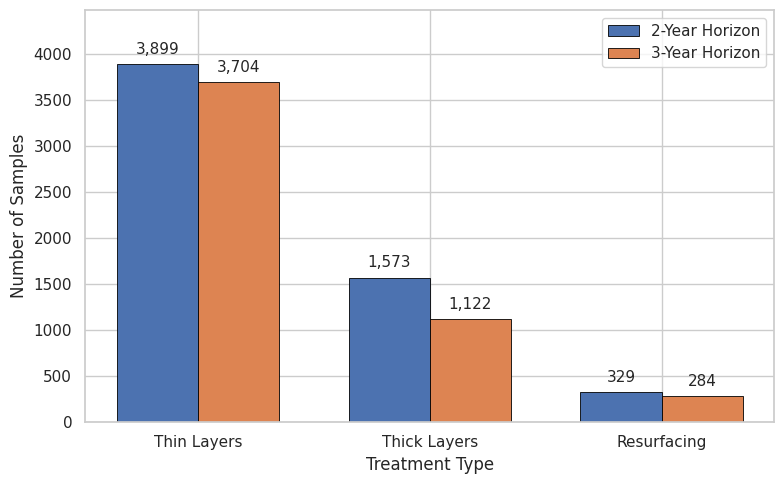

In [24]:
# ===========================
# Bar chart: 2-year vs 3-year counts by treatment
# ===========================
treatments = ['Thin Layers', 'Thick Layers', 'Resurfacing']
two_year = [3899, 1573, 329]
three_year = [3704, 1122, 284]

x = np.arange(len(treatments))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, two_year, width, label='2-Year Horizon', edgecolor="black", linewidth=0.6)
bars2 = ax.bar(x + width/2, three_year, width, label='3-Year Horizon', edgecolor="black", linewidth=0.6)

ax.set_xlabel('Treatment Type')
ax.set_ylabel('Number of Samples')
#ax.set_title('Comparison of Dataset Size by Horizon and Treatment Type')
ax.set_xticks(x)
ax.set_xticklabels(treatments)
ax.legend()

ymax = max(max(two_year), max(three_year))
ax.set_ylim(0, ymax * 1.15)

for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + (0.02 * ymax),
                f"{int(h):,}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

In [25]:
# ===========================
# (Colab) Mount Google Drive if needed
# ===========================
from google.colab import drive
drive.mount('/content/drive')  # Keep mounted in Colab

file_path = "/content/drive/MyDrive/Network Maintenace - With & without maintenace/Code-CRC-conference/Visualizations/output-comparisons-standard.xlsx"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# ===========================
# Helpers: minimal sheet cleaning (keep original % values)
# ===========================
def clean_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Keep metrics as originally given (do NOT convert % to fractions)."""
    # Drop unnamed junk columns
    df = df.loc[:, ~df.columns.astype(str).str.contains(r"^Unnamed", case=False, regex=True)]
    # Strip spaces from column names
    df.columns = [str(c).strip() for c in df.columns]

    # Keep only relevant metrics if they exist
    keep = ["Model","R2","RMSE","MAE","MAPE","VAF","RSR","WMAPE","A20Index"]
    keep_present = [c for c in keep if c in df.columns]
    df = df[keep_present].copy()

    # Make sure Model column is string (no other conversions!)
    if "Model" in df.columns:
        df["Model"] = df["Model"].astype(str).str.strip()

    return df


    # Convert as required
    if "MAPE" in df.columns:   df["MAPE"]   = to_num(df["MAPE"], pct=True)
    if "VAF"  in df.columns:   df["VAF"]    = to_num(df["VAF"],  pct=True)
    if "WMAPE" in df.columns:  df["WMAPE"]  = to_num(df["WMAPE"], pct=True)
    if "RSR"  in df.columns:   df["RSR"]    = to_num(df["RSR"],  auto_pct=True)
    if "MAE"  in df.columns:   df["MAE"]    = to_num(df["MAE"])
    if "R2"   in df.columns:   df["R2"]     = to_num(df["R2"])
    if "RMSE" in df.columns:   df["RMSE"]   = to_num(df["RMSE"])
    if "A20Index" in df.columns: df["A20Index"] = to_num(df["A20Index"])
    if "Model" in df.columns:  df["Model"]  = df["Model"].astype(str).str.strip()
    return df

def read_sheet_resilient(xls: pd.ExcelFile, sheet_name: str) -> pd.DataFrame:
    """Read a sheet even if headers aren't in the first row; detect the row containing 'Model', 'R2', 'RMSE'."""
    df_try = pd.read_excel(xls, sheet_name=sheet_name)
    cols = set(str(c).strip() for c in df_try.columns)
    if {"Model", "R2", "RMSE"}.issubset(cols):
        return df_try

    raw = pd.read_excel(xls, sheet_name=sheet_name, header=None)

    def is_header_row(vals):
        vals = [str(v).strip() for v in vals if pd.notna(v)]
        s = set(vals)
        return {"Model", "R2", "RMSE"}.issubset(s)

    hdr_idx = next((i for i in range(len(raw)) if is_header_row(raw.iloc[i].values)), None)
    if hdr_idx is None:
        raise ValueError(
            f"Header not found in sheet '{sheet_name}'. Inspect the first 20 rows:\n{raw.head(20)}"
        )

    header = raw.iloc[hdr_idx].astype(str).str.strip().tolist()
    block = raw.iloc[hdr_idx+1:].copy()
    block.columns = header

    empty_rows = block.index[block.isna().all(axis=1)]
    if len(empty_rows):
        block = block.loc[: empty_rows.min()-1]

    col_mask = ~pd.Series(header).astype(str).str.contains(r"^Unnamed", case=False, regex=True).values
    block = block.loc[:, col_mask]
    block = block.dropna(how="all")
    return block

# Add this helper
def _coerce_number(x):
    # turn "18.28%" or " 18.28 % " into 18.28; pass-through floats/ints
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip().replace("%", "")
    return float(s)

# Accept aliases like "WMAP"
ALIASES = {
    "WMAPE": ["WMAPE", "WMAP"],
    "R2": ["R2", "R²", "R-squared", "R_square"],
    "RMSE": ["RMSE"],
    "MAE": ["MAE"],
}

def _get_metric_value(block, metric):
    # block = e.g. test_2019["XGBoost"]["Thin Layers"]
    for k in ALIASES.get(metric, [metric]):
        if k in block:
            return _coerce_number(block[k])
    # If not found, show what keys exist to pinpoint the typo
    raise KeyError(f"Metric '{metric}' not found in {list(block.keys())}")

def collect_values(metric):
    """Return values [models × treatments] for given metric, robust to aliases/% strings."""
    vals = []
    for _, data in series:
        row = []
        for t in treatments:
            row.append(_get_metric_value(data[t], metric))
        vals.append(row)
    return np.array(vals, dtype=float)


In [27]:
# ===========================
# Load workbook & read the four sheets (STANDARD SCALING)
# ===========================
try:
    xls = pd.ExcelFile(file_path)
except Exception as e:
    raise FileNotFoundError(
        f"Could not open Excel workbook at:\n{file_path}\n\nOriginal error: {e}"
    )

sheet_names = [
    "2017-2019-maintain-standard",
    "2017-2019-no-maintain-standard",
    "2017-2020-maintain-standard",
    "2017-2020-no-maintain-standard",
]

frames = []
for sh in sheet_names:
    df0 = read_sheet_resilient(xls, sh)
    df = clean_metrics(df0)

    # Metadata
    parts = sh.split('-')
    horizon = f"{parts[0]}-{parts[1]}" if len(parts) >= 2 else "Unknown"
    maintenance = "No Maintenance" if "-no-maintain-" in sh else "Maintenance"
    scaler = "Standard"  # <- sheet names confirm Standard scaling

    df["Horizon"] = horizon
    df["Maintenance"] = maintenance
    df["Scaler"] = scaler
    # Include horizon in the label so hues are unique & informative
    df["Condition"] = f"{maintenance} ({horizon})"
    frames.append(df)

all_df = pd.concat(frames, ignore_index=True)

# Optional: enforce model order
model_order = ["ANN", "Random Forest", "XGBoost", "CatBoost"]
all_df["Model"] = pd.Categorical(all_df["Model"], categories=model_order, ordered=True)

all_df

Model      R2     RMSE      MAE    MAPE     VAF     RSR   WMAPE  \
0             ANN  0.7597  24.0202  15.9347  0.1920  0.7599  0.4902  0.1828   
1   Random Forest  0.8131  21.1838  14.0709  0.1722  0.8133  0.4323  0.1614   
2         XGBoost  0.7967  22.0956  14.6158  0.1782  0.7967  0.4509  0.1676   
3        CatBoost  0.8207  20.7479  13.4240  0.1599  0.8209  0.4234  0.1540   
4             ANN  0.9100  17.2755  10.7619  0.0969  0.9101  0.3001  0.0975   
5   Random Forest  0.8799  19.9496  12.7272  0.1202  0.8803  0.3465  0.1153   
6         XGBoost  0.9173  16.5577   9.9638  0.0870  0.9173  0.2876  0.0903   
7        CatBoost  0.9180  16.4841  10.0150  0.0879  0.9181  0.2863  0.0907   
8             ANN  0.7394  25.8782  16.7092  0.2051  0.7425  0.5105  0.2016   
9   Random Forest  0.7641  24.6207  15.6420  0.1920  0.7650  0.4857  0.1887   
10        XGBoost  0.7747  24.0606  16.0283  0.2019  0.7753  0.4746  0.1934   
11       CatBoost  0.7896  23.2514  15.3513  0.1936  0.7903  0.4587  0.1852   
12            ANN  0.8759  19.4079  11.1590  0.0968  0.8764  0.3523  0.1043   
13  Random Forest  0.8326  22.5368  13.8174  0.1305  0.8328  0.4091  0.1292   
14        XGBoost  0.8824  18.8869  11.1156  0.0987  0.8825  0.3429  0.1039   
15       CatBoost  0.8825  18.8798  11.0894  0.0983  0.8825  0.3427  0.1037   

    A20Index    Horizon     Maintenance    Scaler                   Condition  
0     0.6740  2017-2019     Maintenance  Standard     Maintenance (2017-2019)  
1     0.7316  2017-2019     Maintenance  Standard     Maintenance (2017-2019)  
2     0.7362  2017-2019     Maintenance  Standard     Maintenance (2017-2019)  
3     0.7615  2017-2019     Maintenance  Standard     Maintenance (2017-2019)  
4     0.9026  2017-2019  No Maintenance  Standard  No Maintenance (2017-2019)  
5     0.8228  2017-2019  No Maintenance  Standard  No Maintenance (2017-2019)  
6     0.9326  2017-2019  No Maintenance  Standard  No Maintenance (2017-2019)  
7     0.9233  2017-2019  No Maintenance  Standard  No Maintenance (2017-2019)  
8     0.6217  2017-2020     Maintenance  Standard     Maintenance (2017-2020)  
9     0.6780  2017-2020     Maintenance  Standard     Maintenance (2017-2020)  
10    0.6453  2017-2020     Maintenance  Standard     Maintenance (2017-2020)  
11    0.6688  2017-2020     Maintenance  Standard     Maintenance (2017-2020)  
12    0.8957  2017-2020  No Maintenance  Standard  No Maintenance (2017-2020)  
13    0.7883  2017-2020  No Maintenance  Standard  No Maintenance (2017-2020)  
14    0.8979  2017-2020  No Maintenance  Standard  No Maintenance (2017-2020)  
15    0.9085  2017-2020  No Maintenance  Standard  No Maintenance (2017-2020)

In [28]:
# After building all_df
metric_cols_all = [c for c in ["R2","RMSE","MAE","WMAPE"] if c in all_df.columns]

# Quick check table (R2/RMSE/MAE/WMAPE means by horizon × maintenance)
_agg = all_df.groupby(["Horizon","Maintenance"])[metric_cols_all].mean().round(3)
display(_agg)

# ===========================
# Combined summary table
# ===========================
summary = (
    all_df.groupby(["Horizon","Maintenance"])
          .agg(**{f"{m}_mean": (m, "mean") for m in ["R2","RMSE","MAE"] if m in all_df.columns})
          .round(3)
          .reset_index()
)
print(summary)


R2    RMSE     MAE  WMAPE
Horizon   Maintenance                                 
2017-2019 Maintenance     0.798  22.012  14.511  0.166
          No Maintenance  0.906  17.567  10.867  0.098
2017-2020 Maintenance     0.767  24.453  15.933  0.192
          No Maintenance  0.868  19.928  11.795  0.110

     Horizon     Maintenance  R2_mean  RMSE_mean  MAE_mean
0  2017-2019     Maintenance    0.798     22.012    14.511
1  2017-2019  No Maintenance    0.906     17.567    10.867
2  2017-2020     Maintenance    0.767     24.453    15.933
3  2017-2020  No Maintenance    0.868     19.928    11.795


Compare performances

/tmp/ipython-input-3740625499.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-3740625499.py:44: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-3740625499.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-3740625499.py:44: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-3740625499.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-3740625499.py:44: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-3740625499.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect

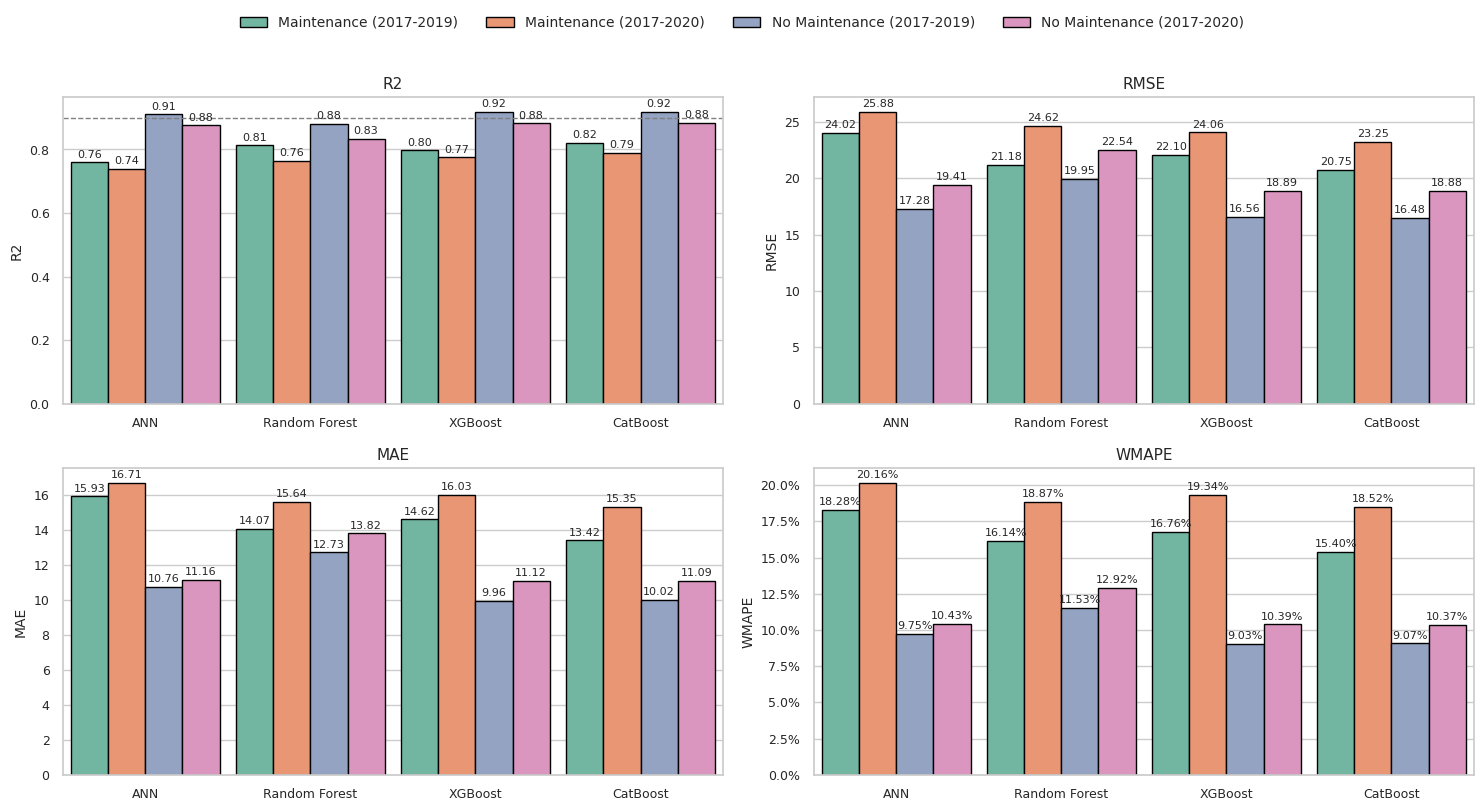

In [29]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# ==========================
# Assumes you already have:
#   - all_df: DataFrame with columns ["Model","Condition","R2","RMSE","MAE","WMAPE", ...]
#   - model_order: list defining the order of models on x-axis
# ==========================

# ---------------------------
# Config
# ---------------------------
metrics_to_plot = [m for m in ["R2", "RMSE", "MAE", "WMAPE"] if m in all_df.columns]

# Palette & hue levels
palette = sns.color_palette("Set2")
hue_levels = sorted(all_df["Condition"].dropna().unique().tolist())

# Layout: always 2 columns; rows as needed
n_metrics = len(metrics_to_plot)
ncols = 2
nrows = math.ceil(n_metrics / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows), sharey=False)

# Normalize axes to a 1D list for easy iteration
if isinstance(axes, (list, tuple)):
    axes = [ax for ax in axes]
else:
    try:
        axes = axes.flatten()
    except Exception:
        axes = [axes]

# To capture global legend entries once
global_handles, global_labels = None, None

# ---------------------------
# Draw each subplot
# ---------------------------
for ax, metric in zip(axes, metrics_to_plot):
    sns.barplot(
        data=all_df,
        x="Model",
        y=metric,
        hue="Condition",
        order=model_order,
        hue_order=hue_levels,
        ci=None,
        ax=ax,
        palette=palette,
        edgecolor="black",
        width=0.90,
    )

    ax.set_title(metric, fontsize=11)
    ax.set_xlabel("", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.tick_params(axis="x", labelsize=9, rotation=0)
    ax.tick_params(axis="y", labelsize=9)

    # Reference line for R²
    if metric == "R2":
        ax.axhline(0.90, ls="--", color="gray", lw=1)

    # WMAPE shown as percent (assuming fraction in data)
    if metric == "WMAPE":
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
        lbl_fmt = lambda v: f"{v*100:.2f}%"
    else:
        lbl_fmt = lambda v: f"{v:.2f}"

    # Numeric labels on bars
    for container in ax.containers:
        try:
            values = [p.get_height() for p in container]
            ax.bar_label(container, labels=[lbl_fmt(v) for v in values], padding=2, fontsize=8)
        except Exception:
            pass

    # Grab legend handles/labels once (before removing subplot legends)
    if global_handles is None or global_labels is None:
        handles, labels = ax.get_legend_handles_labels()
        if handles and labels:
            global_handles, global_labels = handles, labels

    # Remove subplot legend
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# ---------------------------
# Remove any unused axes (when odd number of metrics)
# ---------------------------
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

# ---------------------------
# Add overall legend (figure-level)
# ---------------------------
if global_handles and global_labels:
    fig.legend(
        global_handles,
        global_labels,
        loc="upper center",
        ncol=len(hue_levels) if len(hue_levels) > 0 else 1,
        frameon=False,
        fontsize=10,
        bbox_to_anchor=(0.5, 1.02),  # a bit above the plots
    )

# ---------------------------
# Layout
# ---------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space at top for legend
plt.show()


Heatmaps: unify units and show % for WMAPE

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# Data: paste from your summaries (TEST set used for plots)
# =========================================================
treatments = ["Thin", "Thick", "Resurf."]   # x-axis order
metrics    = ["R2", "RMSE", "MAE", "WMAPE"] # 2x2 panels

# ---- 2017–2019 (XGBoost + ANN) ----
series_2019 = [
    ("XGBoost (2017–2019)", {
        "Thin":   {"R2": 0.7929, "MAE": 15.9536, "RMSE": 23.5456, "WMAPE": "17.18%"},
        "Thick":  {"R2": 0.7786, "MAE": 11.8999, "RMSE": 19.1184, "WMAPE": "15.63%"},
        "Resurf.":{"R2": 0.8117, "MAE": 12.4092, "RMSE": 18.2653, "WMAPE": "16.37%"},
    })
]

# ---- 2017–2020 (XGBoost + ANN) ----
# (ANN values provided match your 2017–2019 block; included as-is.)
series_2020 = [
    ("XGBoost (2017–2020)", {
        "Thin":   {"R2": 0.7743, "MAE": 16.9673, "RMSE": 25.5173, "WMAPE": "18.99%"},
        "Thick":  {"R2": 0.6886, "MAE": 13.3853, "RMSE": 19.0926, "WMAPE": "21.53%"},
        "Resurf.":{"R2": 0.6407, "MAE": 12.7404, "RMSE": 19.0077, "WMAPE": "18.66%"},
    })
]

# =========================================================
# Helpers
# =========================================================
def _coerce_num(x):
    """Tolerate numeric or '17.5%' strings."""
    if isinstance(x, (int, float, np.number)):
        return float(x)
    return float(str(x).strip().replace("%",""))

def collect_values(series, metric):
    """Matrix rows=models, cols=treatments for a given metric."""
    return np.array(
        [[ _coerce_num(data[t][metric]) for t in treatments] for _, data in series],
        dtype=float
    )

def plot_heatmaps(series, title_suffix):
    """Draw 2x2 heatmaps for (R2, RMSE, MAE, WMAPE) for the given series."""
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
    axes = axes.ravel()
    model_labels = [name for name, _ in series]

    for i, metric in enumerate(metrics):
        A = collect_values(series, metric)  # shape: (n_models, n_treatments)
        ax = axes[i]

        # Normalize so "higher color = better"
        plot_vals = A.copy()
        col_min = plot_vals.min(axis=0, keepdims=True)
        col_max = plot_vals.max(axis=0, keepdims=True)
        denom = np.where((col_max - col_min) == 0, 1.0, (col_max - col_min))

        # For error metrics lower is better
        if metric in ("MAE", "RMSE", "WMAPE"):
            plot_vals = 1.0 - (plot_vals - col_min) / denom
        else:  # e.g., R2 higher is better
            plot_vals = (plot_vals - col_min) / denom

        im = ax.imshow(plot_vals, aspect="auto", vmin=0, vmax=1, cmap="viridis")
        ax.set_title(metric)
        ax.set_xticks(np.arange(len(treatments)))
        ax.set_xticklabels(["Thin", "Thick", "Resurf."])
        ax.set_yticks(np.arange(len(model_labels)))
        ax.set_yticklabels(model_labels)

        # Annotate with original values (WMAPE as %)
        for r in range(A.shape[0]):
            for c in range(A.shape[1]):
                val = A[r, c]
                txt = f"{val:.2f}%" if metric == "WMAPE" else f"{val:.2f}"
                ax.text(
                    c, r, txt,
                    ha="center", va="center",
                    color="white" if plot_vals[r, c] < 0.5 else "black"
                )

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.9, location="right", pad=0.04)
    cbar.set_label("Normalized Performance (higher = better color)")

    fig.suptitle(f"Heatmaps — Models × Treatments (per Metric) — {title_suffix}", y=1.02, fontsize=16)
    plt.show()

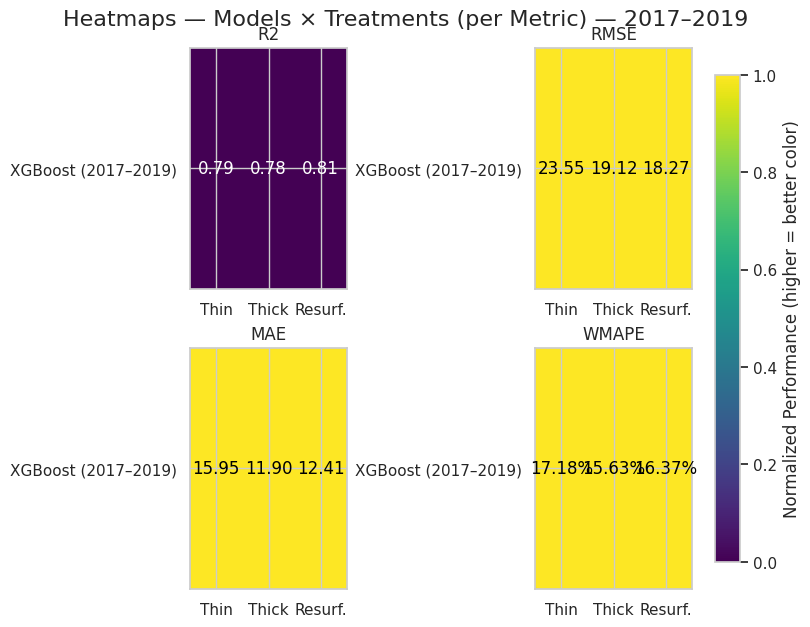

In [31]:
# =========================================================
# Plot both horizons
# =========================================================
plot_heatmaps(series_2019, "2017–2019")


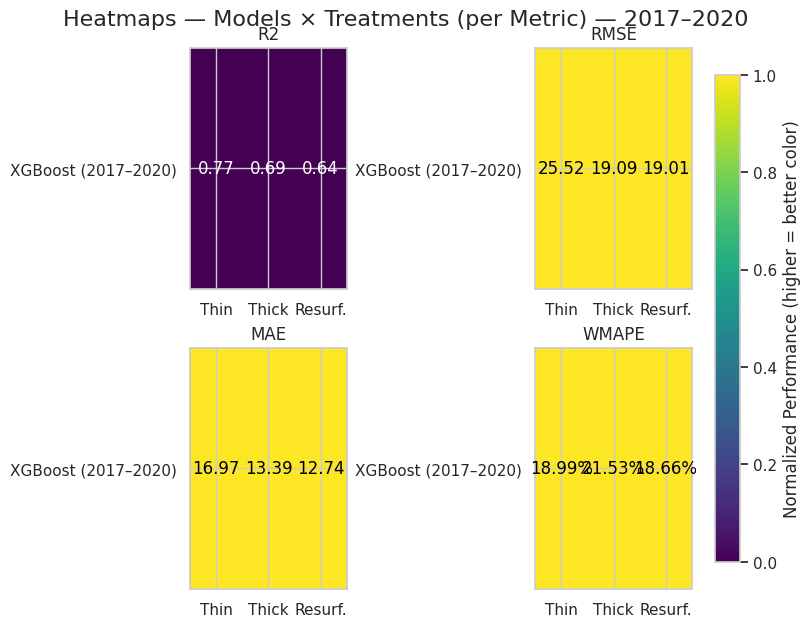

In [32]:
plot_heatmaps(series_2020, "2017–2020")

guard the catplots too

/tmp/ipython-input-103033254.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


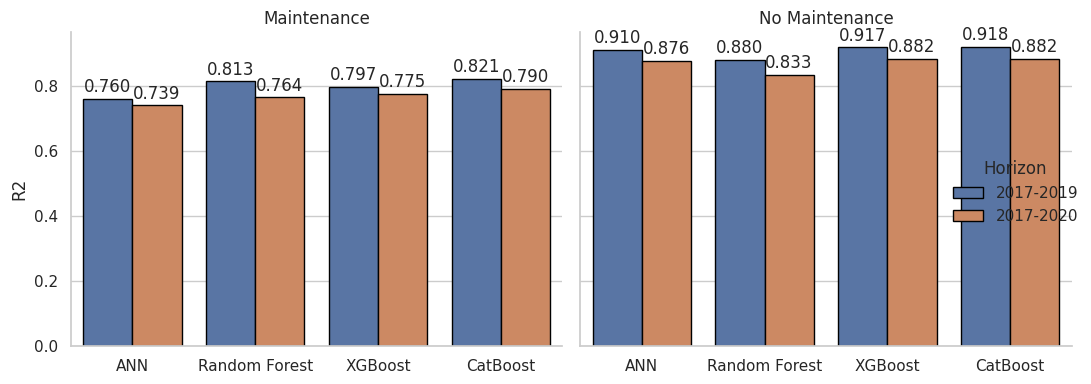

/tmp/ipython-input-103033254.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


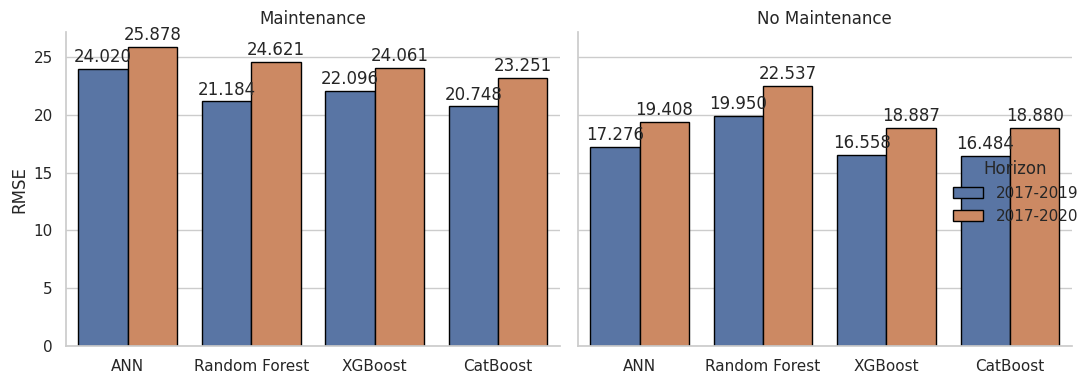

/tmp/ipython-input-103033254.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


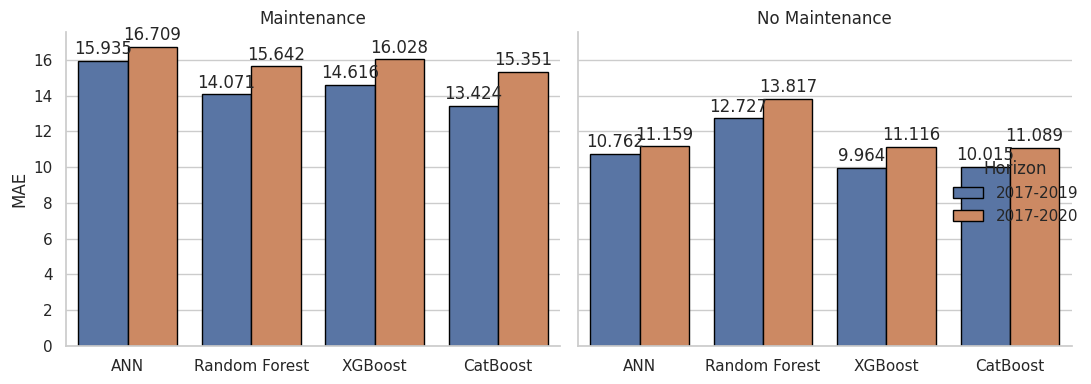

In [33]:
for metric in [m for m in ["R2","RMSE","MAE"] if m in all_df.columns]:
    g = sns.catplot(
        data=all_df, kind="bar",
        x="Model", y=metric, hue="Horizon",
        col="Maintenance", ci=None, height=4, aspect=1.2,
        order=model_order, edgecolor="black"
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("", metric)
    for ax in g.axes.flatten():
        for container in ax.containers:
            try:
                vals = [p.get_height() for p in container]
                ax.bar_label(container, labels=[f"{v:.3f}" for v in vals], padding=2)
            except Exception:
                pass
        ax.tick_params(axis="x", rotation=0)
    plt.tight_layout()
    plt.show()
